In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
% matplotlib inline
plt.ion()

import sys
sys.path.append('../../')
import logomaker

In [2]:
# Set names of matrix files
ww_mat_file = 'matrices/ww_info_matrix.txt'
ss_mat_file = 'matrices/ss_prob_matrix.txt'
crp_mat_file = 'matrices/crp_negenergy_matrix.txt'
ars_mat_file = 'matrices/ars_weight_matrix.txt'
saliency_mat_file = 'matrices/saliency_matrix.txt'

Saliency matrix computed and saved to matrices/saliency_matrix.txt.


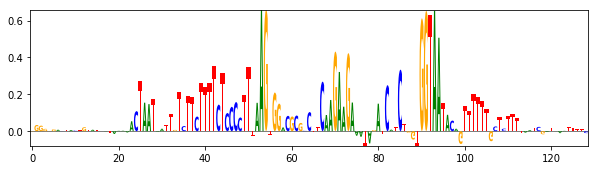

In [3]:
### Create saliency matrix

# saliency matrix
data = np.load('data/importance_score.npz')
saliency_df = pd.DataFrame(data=data['arr_0'].T, columns=list('ACGT'))

# show saliency matrix
logomaker.Logo(saliency_df)

# save file
saliency_df.to_csv(saliency_mat_file, sep='\t')
print('Saliency matrix computed and saved to %s.'%saliency_mat_file)

CRP energy matrix computed and saved to matrices/crp_negenergy_matrix.txt.


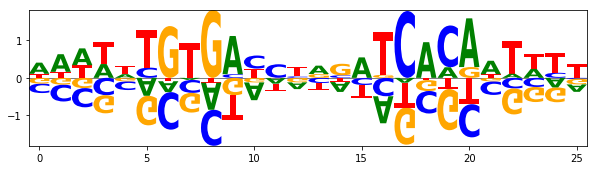

In [4]:
### Create CRP energy matrix

# load published energy matrix
energy_df = pd.read_csv('data/crp_tau_final_all.26.txt', delim_whitespace=True, index_col=0)
energy_df.columns = [c[-1] for c in energy_df.columns]
energy_df = logomaker.transform_matrix(energy_df, center_values=True)

# remember to negate!
negenergy_df = -energy_df

# display energy matrix
logomaker.Logo(negenergy_df)

# save file
negenergy_df.to_csv(crp_mat_file, sep='\t')
print('CRP energy matrix computed and saved to %s.'%crp_mat_file)

ARS enrichment matrix computed and saved to matrices/ars_weight_matrix.txt.


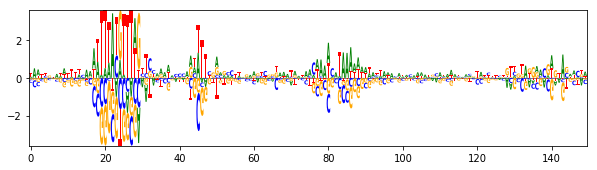

In [5]:
def get_probmat_from_alngz_file(file_name):
    with gzip.open(file_name, 'r') as f:
        txt = [x.decode("utf-8") for x in f]
    
    counts = np.array([int(str(name).strip().split('-')[-1]) for name in txt if '>' in name])
    seqs = [str(s).strip() for s in txt if '>' not in s]
    
    mat = logomaker.alignment_to_matrix(sequences=seqs, 
                                        counts=counts, 
                                        to_type='probability')
    return mat

bg_file = 'data/ARS416_09_B1.qcfilt.aln.full.gz'
fg_file = 'data/ARS416_09_B2.qcfilt.aln.full.gz'

bg_df = get_probmat_from_alngz_file(bg_file)
fg_df = get_probmat_from_alngz_file(fg_file)

enrichment_df = np.log2(fg_df/bg_df)
enrichment_df = logomaker.transform_matrix(enrichment_df, center_values=True)
enrichment_df.loc[:,:] = enrichment_df.values[::-1,::-1]

# show enrichment matrix
logomaker.Logo(enrichment_df)

# save file
enrichment_df.to_csv(ars_mat_file, sep='\t')
print('ARS enrichment matrix computed and saved to %s.'%ars_mat_file)

In [6]:
def rc(seq):
    """Reverse-complements a DNA sequence"""
    complement = str.maketrans('ATCGN', 'TAGCN')
    return str(seq).upper().translate(complement)[::-1]

# write ars416 seq to file
ars416 = rc(
    'tctaacaaaatagcaaatttcgtcaaaaatgctaagaaataggtt'
    'attactgagtagtatttatttaagtattgtttgtgcacttgcctg'
    'caggccttttgaaaagcaagcataaaagatctaaacataaaatct'
    'gtaaaataacaagat'.upper())
with open('matrices/ars416.txt','w') as f:
    f.write(ars416)

WW domain matrix computed and saved to matrices/ww_info_matrix.txt.


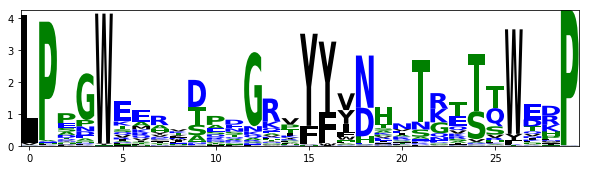

In [7]:
### Create WW domain information matrix

# load alignment of WW domain proteins
in_file = 'data/Pfam_wwdomain.fa'
with open(in_file, 'r') as f:
    text = f.read()
    lines = text.split('\n')
    seqs = [l.strip().upper() for l in lines if '#' not in l and '>' not in l and len(l.strip())>0]
    
# create counts matrix
counts_df = logomaker.alignment_to_matrix(seqs,characters_to_ignore='.-X')

# filter base on counts
num_seqs = counts_df.sum(axis=1)
pos_to_keep = num_seqs > len(seqs)/2
counts_df = counts_df[pos_to_keep]
counts_df.reset_index(drop=True, inplace=True)

# transform to information matrix
info_df = logomaker.transform_matrix(counts_df, from_type='counts', to_type='information')

# display information matrix
logomaker.Logo(info_df)

# save file
info_df.to_csv(ww_mat_file, sep='\t')
print('WW domain matrix computed and saved to %s.'%ww_mat_file)

splice site probability matrix computed and saved to matrices/ss_prob_matrix.txt.


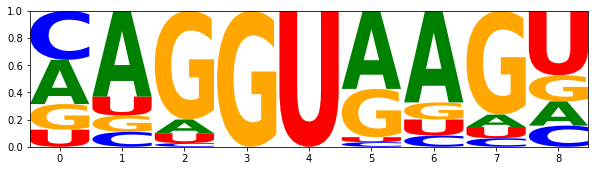

In [8]:
### Create splice site probability matrix

# load all splice sites
df = pd.read_csv('data/hg38_sss.txt', sep='\t', index_col=0)
df.head()

# get 5' splice sites
seqs = [s.replace('T','U') for s in df['ss5_seq'] if s[3:5] in {'GT','GU'}]

# compute probability matrix from sequence alignment
prob_df = logomaker.alignment_to_matrix(seqs, to_type='probability', pseudocount=0)

# display probability matrix
logo = logomaker.Logo(prob_df)

# save file
prob_df.to_csv(ss_mat_file, sep='\t')
print('splice site probability matrix computed and saved to %s.'%ss_mat_file)